In [1]:
%matplotlib inline

In [2]:
import re
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import seaborn as sns

from wordcloud import WordCloud

import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import confusion_matrix, classification_report

import joblib

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# НОВО! Революционен метод за класификация на фалшиви новини!
## by Dimitar Sotirov

Click-bait and fake news continue to invade our lives. It's a serious problem because it spreads misinformation and fear.\
The internet has only made this easier through social media and online news outlets.

Twitter now has algorithms which mark certain tweets with an exclamation point saying that the news are unverified and might not be true. Other websites have similar systems to combat fake news.

### Abstract

In this notebook we explore how we can classify fake news with supervised machine learning methods.

The content of the news is in Bulgarian.\
Firstly because the majority of papers about fake news classificiation are in English.\
Second of all, Bulgarian news have a very different context (themes).

In the following sections we will look at the method which gave the highest base score overall by trying to predict solely on the content alone.\
At the end we look at some ideas on how to further improve the accuracy as well as other methods which didn't quite work.

### The Data set

We will use a corpus of labeled Bulgarian news from previous research (Georgi Karadzhov, Pepa Gencheva, Preslav Nakov, Ivan Koychev, resources available at: https://github.com/gkaradzhov/ClickbaitRANLP). \
They also provide a dictionary of Bulgarian stop words (me is happy >:)).

Reading it is simple enough with pandas:

In [3]:
def read_df(file_path):
    df = pd.read_csv(file_path, sep = "\t", encoding = "utf_8", engine = "c")
    
    df.columns = ["fake_news_score", "click_bait_score", "title", "url", "date_published", "content"]
    df = df[["date_published", "title", "content", "fake_news_score", "click_bait_score"]]
 
    df = df[~df.content.isnull()] # Discard news with no content

    df.date_published = pd.to_datetime(df.date_published)

    return df

In [4]:
news_data = read_df("data/news_data.tsv")

The data set contains a label for fake news and also a label for click-bait. Since they are highly correlated we can just drop one of the columns. Basically an algorithm good at recognizing fake news will be good at classifying click-bait.

In [5]:
news_data.corr()

,fake_news_score,click_bait_score
fake_news_score,1.000000,0.976706
click_bait_score,0.976706,1.000000


In [6]:
news_data = news_data.drop(columns = ["click_bait_score"], errors = "ignore")

In [7]:
news_data.sample(5, random_state = 42)

,date_published,title,content,fake_news_score
2070,2017-01-14 19:36:00,ПРАВИТЕЛСТВЕНО ИЗДАНИЕ НА КИТАЙ ПРЕДУПРЕДИ САЩ...,"Изданието Global Times, част от холдинга на КН...",1
1216,2017-03-07 18:40:00,Ексклузивно: КРАЙ НА ВОЙНАТА В СИРИЯ! Шахматис...,Докато Транснационалните корпорации и техните ...,1
721,2017-04-07 14:17:00,Икономикс за вменяеми. Част 1: Ванга би била г...,През последните десетилетия икономиката и икон...,1
2605,2016-12-03 12:49:00,"Фейсбук демокрация | Портал за култура, изкуст...",03.12.2016 13:49 Социалните мрежи променят тра...,0
2124,2017-01-10 11:42:00,Свят | Политиките на Тръмп може да доведат до ...,"Онези, които търсят голям замисъл зад политики...",0


In [8]:
news_data.shape

(2797, 4)

... that is a rather small data set. To make sure our text vectorizer has reasonably enough data we will use a sub-corpus from the [Bulgarian National Corpus](http://dcl.bas.bg/bulnc/en/) - in particular a large collection of news from Eastern Europe written in Bulgarian.

Note that we don't need these to be labeled as real/fake (although we assume they are real because the people at BNC say they manually look through all of them). But we just need them to train the vectorizer so it does a decent job of converting our text to numbers.

In [9]:
# Credit for this gem: OLIVER MU:LLER https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf
# This makes sure we don't try to read directly from google drive (since that is very slow)
# zip_path = "./JOURNALISM.BG.zip"
# !cp "{zip_path}" .
# !unzip -q JOURNALISM.BG.zip
# !rm JOURNALISM.BG.zip
#
#
# NEVERMIND. WE NOW READ IT DIRECTLY FROM A .PLK FILE BECAUSE IT TAKES AGES OTHERWISE!

In [10]:
#
#
# NEVERMIND. WE NOW READ IT DIRECTLY FROM A .PLK FILE BECAUSE IT TAKES AGES OTHERWISE!
#
#

def read_journalism_corpus(dir):
    df = pd.read_csv(dir + "JOURNALISM_METADATA.BG.txt", sep = "\t", low_memory = False)

    titles = []
    for title in (df.title):
        titles.append(str(title))

    # The data set includes the path to the actual file (and not the content directly).
    contents = []
    for path in (dir + df.path):
        with open(path, encoding = "utf-8") as file:
            contents.append(file.read())

    return titles, contents

In [11]:
# journalism_corpus_titles, journalism_corpus_contents = read_journalism_corpus("./JOURNALISM.BG/")

In [12]:
journalism_corpus_titles = joblib.load("data/journalism_titles.plk")
journalism_corpus_contents = joblib.load("data/journalism_contents.plk")

In [13]:
len(journalism_corpus_contents)

35337

### The Vectorizer

Finally let's read the set of stop words and train the TF-IDF vectorizer.

* Note: Using methods as Doc2Vec/Word2Vec didn't give good results (~60%/70% accuracy).

Going back to the basics, turns out a bag of words is enough to tell both classes apart reasonably well.

But before that we need to cleanup the text. We will do that and save it directly to the data set.

In [14]:
stop_words = None
with open("data/bg_stopwords.txt", encoding = "utf-8") as file:
    stop_words = set(file.read().split())

# Tfid warns us that some stop words are not included in our set... 
# Manually looking at them, they really should be.
stop_words = stop_words.union({"кои", "маи", "наи", "никои", "твои", "тои", "тъи"})

In [15]:
def cleanup(text):
    text = re.sub("[\(\[].*?[\)\]]", "", text) # Remove content in () or [], most commonly these include the site name/author/source etc.
    text = re.sub("\d+", "", text) # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove rest of punctuation
    words = re.split(r"\W+", text.lower()) # Split by words and convert to lower case
    words_filtered = [w for w in words if not w in stop_words and w != ""] # Remove stop words 
    text = " ".join(words_filtered) # Return the content
    return text

In [16]:
def cleanup_texts(texts):
    result = []
    for t in texts:
        result.append(cleanup(t))
    return result

In [17]:
news_data.title = cleanup_texts(news_data.title)

news_data["content_original"] = news_data.content # We save the original because later we do some feature engineering
news_data.content = cleanup_texts(news_data.content)

journalism_corpus_titles = cleanup_texts(journalism_corpus_titles)

journalism_corpus_contents_original = journalism_corpus_contents
journalism_corpus_contents = cleanup_texts(journalism_corpus_contents)

We train the vectorizer on the big daddy:

In [18]:
vectorizer = TfidfVectorizer(strip_accents = None, lowercase = False, max_df = 0.8, min_df = 20, stop_words = stop_words)
vectorizer.fit(journalism_corpus_contents)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=0.8, max_features=None,
                min_df=20, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'а', 'автентичен', 'аз', 'ако', 'ала', 'бе', 'без',
                            'беше', 'би', 'бивш', 'бивша', 'бившо', 'бил',
                            'била', 'били', 'било', 'благодаря', 'близо',
                            'бъдат', 'бъде', 'бяха', 'в', 'вас', 'ваш', 'ваша',
                            'вероятно', 'вече', 'взема', 'ви', 'вие', ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [19]:
# joblib.dump(journalism_corpus_contents, "data/journalism_contents.plk")
# joblib.dump(journalism_corpus_titles, "data/journalism_titles.plk")

### Frequency Visualization

We can see that fake news have a drastically different word cloud:

In [20]:
word_text_journalism = " ".join(journalism_corpus_contents)
word_text_fake = " ".join(news_data[news_data.fake_news_score == 1].content)

In [21]:
word_cloud_journalism = WordCloud(background_color = "white", width = 700, height = 350).generate(word_text_journalism)
word_cloud_fake = WordCloud(background_color = "white", width = 700, height = 350).generate(word_text_fake)

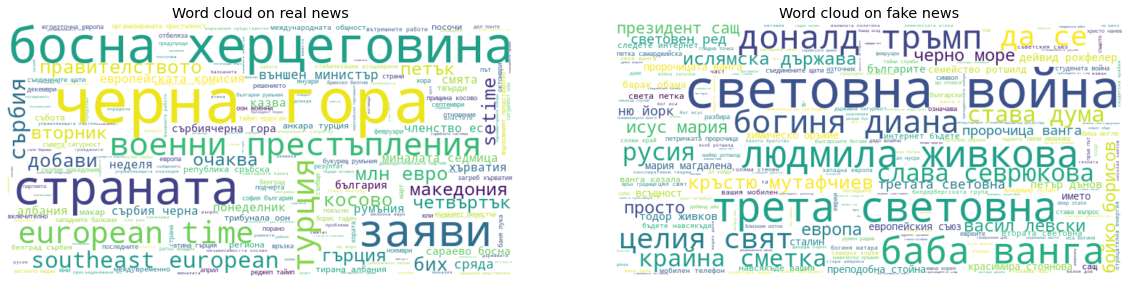

In [22]:
plt.figure(figsize = (20, 20))

plt.subplot(1, 2, 1)
plt.title("Word cloud on real news")
plt.imshow(word_cloud_journalism, interpolation = "bilinear")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Word cloud on fake news")
plt.imshow(word_cloud_fake, interpolation = "bilinear")
plt.axis("off")

plt.show()

* Remember that for now we focus just on the news content, we will take a look at other features later!

### Balancing the Data set

We can see that our data set is imbalanced:

In [23]:
y = np.array(news_data.fake_news_score)

In [24]:
print(sum(y) / len(y))

0.6889524490525563


In [25]:
sum(y)

1927

In order to correct that, let's take a random sample of news from the journalism corpus:

In [26]:
news_data_attributes = news_data[["title", "content", "content_original", "fake_news_score"]].copy()

random.seed(42)
sample_size = sum(y) - (len(y) - sum(y))
sample_contents, sample_contents_original = zip(
    *random.sample(
        list(zip(journalism_corpus_contents, journalism_corpus_contents_original)),
        k = sample_size
        )
    )

for index in range(sample_size):
    # We append the title, content and give it a fake_news_score of 0
    to_append = pd.Series(["", sample_contents[index], sample_contents_original[index], 0], index = news_data_attributes.columns)
    news_data_attributes = news_data_attributes.append(to_append, ignore_index = True)

In [27]:
y = np.array(news_data_attributes.fake_news_score)

In [28]:
sum(y) / len(y)

0.5

In [29]:
X = vectorizer.fit_transform(news_data_attributes.content)
joblib.dump(vectorizer, "data/Tfidf.plk")

['data/Tfidf.plk']

### Dimensionality Reduction and Visualization

`Tfidf` gives us ~10 000 features.

* Note: Without setting the `min_df`, `max_df` parameters on `Tfidf`, the resulting number of features was around 100 000.\
That takes an ungodly amount of RAM to do PCA on!

Now let's enter the magical world of dimensionality reduction~ (and pretty plots!).

In [30]:
pca = PCA()
pcs = pca.fit_transform(X.toarray()) 

In [31]:
pca.explained_variance_ratio_

array([1.21704065e-02, 1.18350782e-02, 8.79933097e-03, ...,
       3.09420543e-37, 1.40255774e-37, 1.78268191e-38])

In [32]:
explained_variance_cumsum = np.cumsum(pca.explained_variance_ratio_)

We see that the first around 1500 features explain 95% of the variance.

We hardcode 1587 features because we deploy later and we don't want any problems.\
(We got those from `len(explained_variance_cumsum[explained_variance_cumsum < 0.95])`)

We will use `features_reduced` for training the algorithms later.\
We'll also feed them to t-SNE in just a bit..

In [33]:
features_reduced = pcs[:, :1587]

num_important_features = 1587 # len(explained_variance_cumsum[explained_variance_cumsum < 0.95])
num_important_features

1587

In [34]:
pca_deploy = PCA(n_components = num_important_features)
pca_deploy.fit(X.toarray())

PCA(copy=True, iterated_power='auto', n_components=1587, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [35]:
joblib.dump(pca_deploy, "data/PCA_deploy.plk")

['data/PCA_deploy.plk']

In [36]:
def plot_2_principal_components(first_pc, second_pc, target, title, figsize = (10, 5), show = True):
    if figsize is not None: plt.figure(figsize = figsize)

    df = pd.DataFrame({"pca-one": first_pc, "pca-two": second_pc, "y": target})

    plt.title(title)
    sns.scatterplot(
        x = "pca-one", y = "pca-two",
        hue = "y",
        palette = sns.color_palette("hls", 2),
        data = df,
        legend = "full",
        alpha = 0.3
    )
    if show: plt.show()

For the sake of it, let's plot a 2-component PCA:

In [37]:
pca_2 = PCA(n_components = 2)
pcs_2 = pca_2.fit_transform(features_reduced)

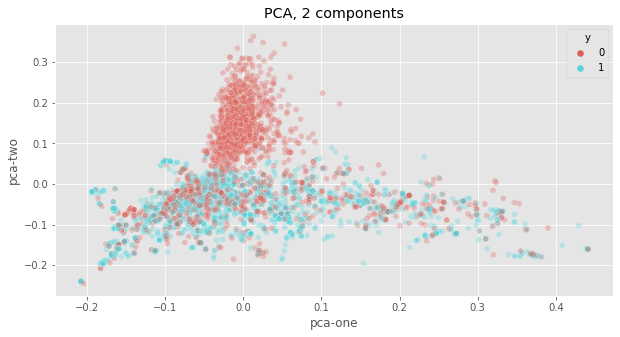

In [38]:
plot_2_principal_components(pcs_2[:, 0], pcs_2[:, 1], y, f"PCA, 2 components")

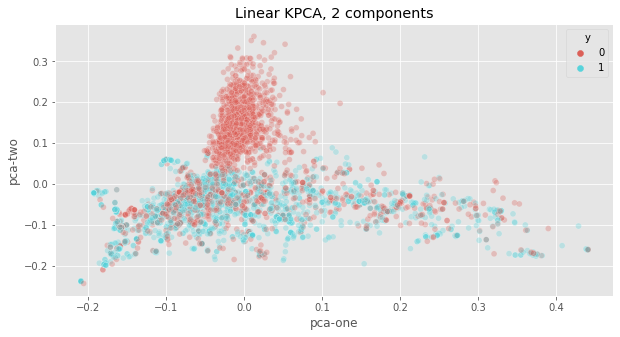

In [39]:
kpca_2 = KernelPCA(n_components = 2, kernel = "linear")
kpcs_2 = kpca_2.fit_transform(features_reduced)
plot_2_principal_components(kpcs_2[:, 0], kpcs_2[:, 1], y, f"Linear KPCA, 2 components")

In [40]:
# For brevity I've uncommented these but they don't look too differently!

# kpca_2 = KernelPCA(n_components = 2, kernel = "sigmoid", gamma = 0.1)
# kpcs_2 = kpca_2.fit_transform(features_reduced)
# plot_2_principal_components(kpcs_2[:, 0], kpcs_2[:, 1], y, f"Sigmoid KPCA, 2 components")

In [41]:
tsne = TSNE(n_components = 2, n_iter = 3000, verbose = 1, random_state = 42)
tsne_result = tsne.fit_transform(features_reduced)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3854 samples in 0.765s...
[t-SNE] Computed neighbors for 3854 samples in 51.227s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3854
[t-SNE] Computed conditional probabilities for sample 2000 / 3854
[t-SNE] Computed conditional probabilities for sample 3000 / 3854
[t-SNE] Computed conditional probabilities for sample 3854 / 3854
[t-SNE] Mean sigma: 0.369089
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.924736
[t-SNE] KL divergence after 3000 iterations: 1.169714


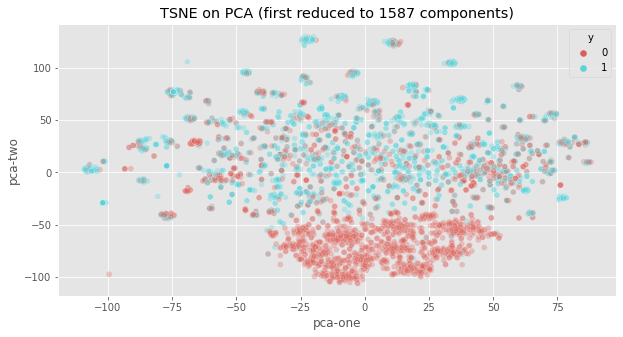

In [42]:
plot_2_principal_components(tsne_result[:, 0], tsne_result[:, 1], y, f"TSNE on PCA (first reduced to {features_reduced.shape[1]} components)")

Doesn't look bad!\
There is definetely some separation between the two classes which gives us some hope!!! Hope I tell you.... >_>

### Baseline

Training a `MultinomialNB` on all features gives us a nice baseline of 80% accuracy.

In [43]:
y = news_data_attributes.fake_news_score
X = X   # Full features (no PCA), straight from the vectorizer

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y, random_state = 42)

In [44]:
nb = MultinomialNB()
nb.fit(X_train_full, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [45]:
print("Train score: ", nb.score(X_train_full, y_train))
print("Test score: ", nb.score(X_test_full, y_test))

Train score:  0.8238728511190399
Test score:  0.8002594033722439


### Train test split

With a relatively small data set we need a somewhat big testing set.

Around 0.8 leaves us with ~700 records to test our little child in the end.

In any way cross-validation is mandatory...

In [46]:
y = news_data_attributes.fake_news_score
X = features_reduced

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y, random_state = 42)

In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3083, 1587), (771, 1587), (3083,), (771,))

### .. The SEARCH IS ON!

Now we try train several different algorithms and perform a grid search to tune the hyperparameters.

In [48]:
lr = LogisticRegression(random_state = 42, max_iter = 500)
svm = SVC(random_state = 42)
nb = MultinomialNB()

In [49]:
grid_params_lr = [{"solver": ["liblinear"], # liblinear handles specifically 1 vs rest classification 
                   "fit_intercept": [False],
                   "C": np.logspace(-3, 2, 6)}] 

grid_params_svm = [{"kernel": ["rbf", "sigmoid"],
                    "C": np.logspace(-3, 2, 5),
                    "gamma": np.logspace(-1, 1, 3)}]

# NB trains so fast it doesn't matter how much parameters we give it.. lol
grid_params_nb = [{"alpha": np.logspace(-5, 10, 16)}]

Since we balanced the data set, just accuracy will a good metric.

We also use `verbose = 10` so it prints information about progress.\
It's a lot lot lot lot less nerve-racking than staring at an emotionless progress circle .. thing..

In [50]:
gs_lr = GridSearchCV(estimator = lr, param_grid = grid_params_lr,
                     cv = 5, verbose = 10, n_jobs = -1) 

gs_svm = GridSearchCV(estimator = svm, param_grid = grid_params_svm,
                      cv = 3, verbose = 10, n_jobs = -1)

gs_nb = GridSearchCV(estimator = nb, param_grid = grid_params_nb,
                     cv = 5, verbose = 10, n_jobs = -1)

In [51]:
def run_grid(gs, train_attributes, train_target, name):
    print('\nEstimator: %s' % name)

    gs.fit(train_attributes, train_target)
    print("Best params: %s" % gs.best_params_)

    accuracy = gs.best_score_
    print("Best validation accuracy: %.3f" % accuracy)

In [52]:
# run_grid(gs_lr, X_train, y_train, "Logistic Regression")
# run_grid(gs_svm, X_train, y_train, "Support Vector Machines")
# run_grid(gs_nb, X_train_full, y_train, "Naive Bayes")

# Running everything takes a long long time! My laptop can't handle it... 

The final results are:

In [53]:
# Estimator: Logistic Regression
# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# Best params: {'C': 10.0, 'fit_intercept': False, 'solver': 'liblinear'}
# Best validation accuracy: 0.820
 
# Estimator: Support Vector Machines
# Fitting 3 folds for each of 30 candidates, totalling 90 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
# Best params: {'C': 5.623413251903491, 'gamma': 1.0, 'kernel': 'rbf'}
# Best validation accuracy: 0.810

# Estimator: Naive Bayes
# Fitting 5 folds for each of 16 candidates, totalling 80 fits
# Best params: {'alpha': 1e-05}
# Best validation accuracy: 0.792

Let's dump them to disk so we can reuse them later:

In [54]:
# joblib.dump(gs_lr, "data/gs_lr.pkl")
# joblib.dump(gs_svm, "data/gs_svm.pkl")
# joblib.dump(gs_nb, "data/gs_nb.pkl")

# (The grid searches are already saved on disk)

Let's start with the Logistic Regression since it got the highest score:

In [64]:
gs_lr = joblib.load("data/gs_lr.pkl")
print(gs_lr.best_params_)
print("Train score: ", gs_lr.best_estimator_.score(X_train, y_train))
print("Test score: ", gs_lr.best_estimator_.score(X_test, y_test))

# THESE ACTUALLY ARE THE WRONG SCORES VVV
# It's a bug with serialization I guess..
# They were around 93 for train and 81 for testing or sth like that
# THESE ACTUALLY ARE THE WRONG SCORES VVV


{'C': 10.0, 'fit_intercept': False, 'solver': 'liblinear'}
Train score:  0.38890690885501134
Test score:  0.3748378728923476


Hmm.. seems to be overfitting.

Let's look at the other parameters:

In [65]:
gs_lr.cv_results_

{'mean_fit_time': array([0.23778939, 0.35416212, 0.5408    , 0.92855215, 1.77956862,
        3.28978505]),
 'std_fit_time': array([0.07900456, 0.05856312, 0.1050059 , 0.14949543, 0.30565493,
        0.52485852]),
 'mean_score_time': array([0.00415077, 0.00391908, 0.00557151, 0.0022779 , 0.00227327,
        0.0055182 ]),
 'std_score_time': array([3.36716159e-03, 3.29089942e-03, 6.45030086e-03, 2.94086780e-05,
        4.44762558e-05, 3.98358126e-03]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[False, False, False, False, False, False],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['liblinear', 'liblinear', 'liblinear', 'liblinear',
                    'liblinear', 'liblinear'],
              mask=[False, 

If we choose a higher regulization we get something with a lot less variance:

In [66]:
print(gs_lr.cv_results_["params"][3])

{'C': 1.0, 'fit_intercept': False, 'solver': 'liblinear'}


In [67]:
temp_lr = LogisticRegression(C = 1.0, fit_intercept = False, solver = "liblinear")
temp_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
print("Train score: ", temp_lr.score(X_train, y_train))
print("Test score: ", temp_lr.score(X_test, y_test))

Train score:  0.8738241972105092
Test score:  0.8197146562905318


It's also more accurate than our baseline:

In [69]:
gs_nb = joblib.load("data/gs_nb.pkl")

print("Naive Bayes validation best score: ", gs_nb.best_score_)
print("Logistic Regression validation score: ", gs_lr.cv_results_["mean_test_score"][3])

Naive Bayes validation best score:  0.7920867625081564
Logistic Regression validation score:  0.8076548653939254


In [70]:
# winner = temp_lr
# joblib.dump(temp_lr, "winner.plk")

# Winner is already saved on disk:
winner = joblib.load("data/winner.plk")

In [71]:
print(classification_report(y_test, winner.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       386
           1       0.77      0.92      0.84       385

    accuracy                           0.82       771
   macro avg       0.83      0.82      0.82       771
weighted avg       0.83      0.82      0.82       771



In [72]:
def plot_cm(estimator, attributes, target, title):
    cm = confusion_matrix(target, estimator.predict(attributes), normalize = "all")
    
    plt.figure(figsize = (3, 3))
    plt.title(title)
    sns.heatmap(cm, annot = cm, fmt = ".1%", cmap = plt.cm.Blues, xticklabels = estimator.classes_, yticklabels = estimator.classes_)
    plt.show()

* Note: Remember that 0 means real, 1 means fake news.

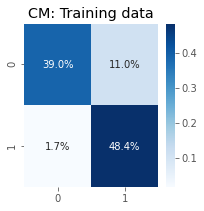

In [73]:
plot_cm(winner, X_train, y_train, "CM: Training data")

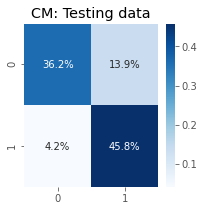

In [74]:
plot_cm(winner, X_test, y_test, "CM: Testing data")

### Other Features

We can play around with the title and vectorize it and see what we can get.

But let's do some actual feature engineering...

There are these things called measures for readibility.\
It's a number which tells you how hard a given text is to comprehend.

The first of the features we are going to calculate is the [Flesch Readibility Ease](https://datawarrior.wordpress.com/2016/03/29/flesch-kincaid-readability-measure/).\
It's proven to be quite good for English... But let's apply it to Bulgarian anyway.\
Interestingly enough there is a severe lack of research in that area.
* Note: This is a really interesting topic for a future paper. We need good measures for Bulgarian! 

In [75]:
def flesch_readability_ease(t):
    word_count = len(word_tokenize(t))
    sent_count = len(sent_tokenize(t))

    # Fortunately, counting syllables in Bulgarian is way easier than in English!
    vowel_count = {"а": 0, "ъ": 0, "о": 0, "у": 0, "е": 0, "и": 0, "ю": 0, "я": 0}
    for ch in t:
        if ch in vowel_count.keys():
            vowel_count[ch] += 1
    
    syllable_count = 0
    for k, v in vowel_count.items():
        syllable_count += v

    return 206.835 - 1.015 * word_count / sent_count - 84.6 * syllable_count / word_count

Some other features which may corellate to the complexity of the text is the words to characters ratio; average word length and the average sentence length.\
[And I'm not making these up randomly.](https://www.mind-print.com/diploma/4-2.php)

In [76]:
def words_to_characters_ratio(t):
    words = word_tokenize(t)
    return len(words) / len(t)

def average_word_length(t):
    words = word_tokenize(t)
    return len("".join(words)) / len(words)

def average_sent_length(t):
    sents = sent_tokenize(t)
    return len("".join(sents)) / len(sents)

In [77]:
def add_feature(df, column_src, target_column, lamba):
    values = []
    for row in df[column_src]:
        values.append(lamba(row))
    df[target_column] = values
    return df

In [78]:
news_data_attributes = add_feature(news_data_attributes, 
                                   "content_original", "flesch_readability_ease", lambda x: flesch_readability_ease(x))
news_data_attributes = add_feature(news_data_attributes, 
                                   "content_original", "words_to_characters_ratio", lambda x: words_to_characters_ratio(x))
news_data_attributes = add_feature(news_data_attributes, 
                                   "content_original", "average_word_length", lambda x: average_word_length(x))
news_data_attributes = add_feature(news_data_attributes, 
                                   "content_original", "average_sent_length", lambda x: average_sent_length(x))

In [79]:
news_data_attributes.sample(5, random_state = 42)

,title,content,content_original,fake_news_score,flesch_readability_ease,words_to_characters_ratio,average_word_length,average_sent_length
3214,,основните партии бих потвърждават подкрепата п...,основните партии бих потвърждават подкрепата п...,0,-179.799014,0.103048,8.718310,689.000000
457,трета световна започва,екстрасенса хорасио вийегас правилно предрече ...,"Според екстрасенса Хорасио Вийегас, който прав...",1,51.738889,0.205882,4.062857,93.555556
291,найстраховитите пророчества ванга,каквото кажем ванга случайно определят феномен...,"Каквото и да кажем за Ванга, винаги ще е малко...",1,61.770024,0.212121,3.868132,46.777778
3788,,взрив парламента косово причини материални щет...,взрив парламента косово причини материални щет...,0,-123.885000,0.116223,7.625000,413.000000
1681,огромна база извънземните откри уфолог луната,мрежата качена информация потребител занимаващ...,"Преди дни в мрежата е качена информация, на ко...",1,29.372325,0.187176,4.471287,98.962963


In [80]:
train_attributes = news_data_attributes[["flesch_readability_ease", 
                                         "words_to_characters_ratio", 
                                         "average_word_length", 
                                         "average_sent_length"]]

Scaling doesn't hurt I guess (as long as it's not `Tfidf` as I learned the hard way..)

In [81]:
X_2 = MinMaxScaler().fit_transform(train_attributes.to_numpy())
y = news_data_attributes.fake_news_score

X_train_2, X_test_2, y_train, y_test = train_test_split(X_2, y, train_size = 0.8, stratify = y, random_state = 42)

In [82]:
X_2.shape

(3854, 4)

We are not gonna do the whole grid search fiasco again..\
Let's just pull some levers and ... it's overfitting just a little bit now.. Ok bring down the learning rateee.. OK good.

In [83]:
ada = AdaBoostClassifier(RandomForestClassifier(max_depth = 1), n_estimators = 50, learning_rate = 0.3)
ada.fit(X_train_2, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                          

In [84]:
print("Train score: ", ada.score(X_train_2, y_train))
print("Test score: ", ada.score(X_test_2, y_test))

Train score:  0.7745702238079792
Test score:  0.7976653696498055


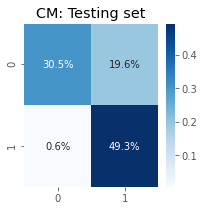

In [85]:
plot_cm(ada, X_test_2, y_test, "CM: Testing set")

### One final thing

We can combine the two estimators and weight their predicted probability for each class.\
After that we take whatever is highest.

In [86]:
def predict_with_soft_voting(attributes, attributes_2, weights):
    p1 = winner.predict_proba(attributes)
    p2 = ada.predict_proba(attributes_2)
    avg = np.average([p1, p2], axis = 0, weights = weights)
    return np.argmax(avg, axis = 1)

In [87]:
print("Training set:")
print(classification_report(y_train, predict_with_soft_voting(X_train, X_train_2, [0.5, 0.5])))

Training set:
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1541
           1       0.81      0.97      0.88      1542

    accuracy                           0.87      3083
   macro avg       0.88      0.87      0.87      3083
weighted avg       0.88      0.87      0.87      3083



In [88]:
print("Testing set:")
print(classification_report(y_test, predict_with_soft_voting(X_test, X_test_2, [0.5, 0.5])))

Testing set:
              precision    recall  f1-score   support

           0       0.90      0.71      0.80       386
           1       0.76      0.92      0.84       385

    accuracy                           0.82       771
   macro avg       0.83      0.82      0.82       771
weighted avg       0.83      0.82      0.82       771



It didn't really do much. It actually overfitted a little.

Ok not sure if this is smart but let's plot the t-SNE again but with the estimator predictions.\
That way we can see if there is common ground between the two (if there is then they are not really helping each other).

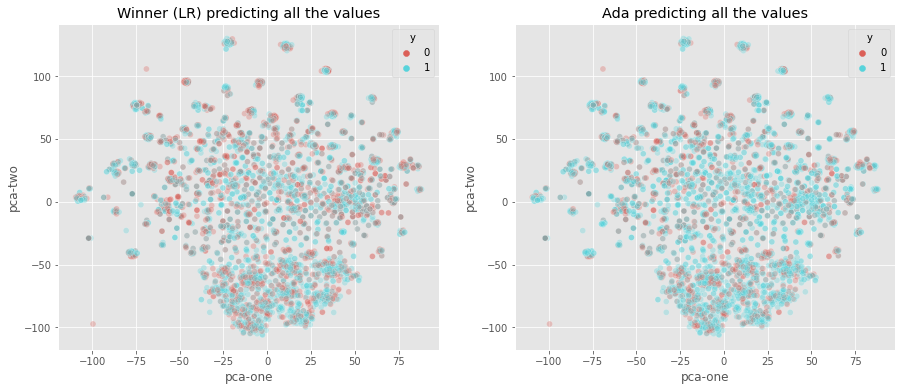

In [93]:
plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
plot_2_principal_components(tsne_result[:, 0], tsne_result[:, 1], 
                            winner.predict(np.append(X_train, X_test, axis = 0)), 
                            "Winner (LR) predicting all the values",
                            figsize = None, show = False)
plt.subplot(1, 2, 2)
plot_2_principal_components(tsne_result[:, 0], tsne_result[:, 1], 
                            ada.predict(np.append(X_train_2, X_test_2, axis = 0)), 
                            "Ada predicting all the values",
                            figsize = None, show = False)
plt.show()


### Preparing for Deployment!

We suspect that the corpus contains only real news.\
So let's try it with our model!

In order to do that we need to setup a pipeline from start to end (which will lead us right to deployment.. hehe).

In [94]:
dummy_content = "Predict me, father"
dummy_content

'Predict me, father'

In [95]:
cleaned = cleanup(dummy_content)
cleaned 

'predict me father'

In [96]:
dummy_vector = vectorizer.transform([cleaned])

pca_deploy = joblib.load("data/PCA_deploy.plk")
X_dummy = pca_deploy.transform(dummy_vector.toarray())

In [97]:
X_dummy.shape

(1, 1587)

In [98]:
winner.predict(X_dummy)

array([0])

\
\
Now let's combine all of that into a program:

In [99]:
stop_words = None
with open("data/bg_stopwords.txt", encoding = "utf-8") as file:
    stop_words = set(file.read().split())
stop_words = stop_words.union({"кои", "маи", "наи", "никои", "твои", "тои", "тъи"})

def cleanup(text):
    text = re.sub("[\(\[].*?[\)\]]", "", text) # Remove content in () or [], most commonly these include the site name/author/source etc.
    text = re.sub("\d+", "", text) # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove rest of punctuation
    words = re.split(r"\W+", text.lower()) # Split by words and convert to lower case
    words_filtered = [w for w in words if not w in stop_words and w != ""] # Remove stop words 
    text = " ".join(words_filtered) # Return the content
    return text

vectorizer = joblib.load("data/Tfidf.plk")
pca_deploy = joblib.load("data/PCA_deploy.plk")
winner = joblib.load("data/winner.plk")

In [100]:
pipe = Pipeline(steps = [
  ("cleanup", FunctionTransformer(lambda x: [cleanup(t) for t in x])),
  ("vectorizer", vectorizer),
  ("to_dense", FunctionTransformer(lambda x: x.toarray())),
  ("dimensionality_reduction", pca_deploy),
  ("model", winner)
], verbose = True)

In [101]:
pipe.predict(["Босна и Херцеговина"])

array([0])

In [102]:
pipe.predict(["баба Ванга"])

array([1])

\
\
Let's try it on the journalism corpus:

In [103]:
predictions = pipe.predict(journalism_corpus_contents)

In [104]:
sum(predictions) / len(predictions) * 100

0.07357727028327249

99.94% of the sub-corpus is real knews... Good to know!

### Some things left:
* Extracting more features from the content / text measures
* Improving the algorithm that uses them ^ to predict (maybe adaboost is not the best one?)
* This will inturn improve the final algorithm (the weighted softvoting one)


###

Thanks for reading!

(Last edited: 13.11.2020)

### References

* Georgi Karadzhov and Pepa Gencheva and Preslav Nakov and Ivan Koychev, "We Built a Fake News & Click-bait Filter: What Happened Next Will Blow Your Mind!", September 2017, Varna, Bulgaria: https://acl-bg.org/proceedings/2017/RANLP%202017/pdf/RANLP045.pdf


* Resources used in the paper above (data set and stop words): https://github.com/gkaradzhov/ClickbaitRANLP


* Български национален корпус (Bulgarian National Corpus): https://dcl.bas.bg/bulnc/en/, JOURNALISM.BG.zip (Новини от Източна Европа)


* stephenhky, 2016, "Flesch-Kincaid Readability Measure": https://datawarrior.wordpress.com/2016/03/29/flesch-kincaid-readability-measure/


* "АЛГОРИТМИ И ПРОГРАМИ В ТЕКСТООБРАБОТКАТА", ФМИ, 1995, София: https://www.mind-print.com/diploma/4-2.php

